<h1>NIH Chest X-Ray Deep Learning</h1>

<h3>Introduction</h3>

<p>For this notebook I'll actually try to dive in and work on some classification. For the first attempts at this problem I'll just be doing a classification problem with overlab. So our final layer will be a fully connected softmax that shows the most likely diseases that are present in a single chest x-ray image.</p>

<p>Along the way I'll be investigating some neural network architecture as well as trying to visualize some of what's going on with the network as we're building the deep learning framework.</p>

<p>For this first iteration we'll be using the VGG19 Neural Network architecture. We'll load in the network sans head and then create a new structure for the final fully connected layers.</p>

<img src="notebook_images/vgg_19.jpeg">

In [63]:
import os
import sys
import PIL
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import keras
from keras import applications as applications
from keras import preprocessing as preprocessing
from keras import models as models
from keras import layers as layers

<h3>Model Introduction</h3>

<p>We'll be using the VGG Convolutional Neural Network to try to classify our chest x-ray images. This network is known to perform well on image classification and is frequently distributed in pretrained configurations. For the network we'll be using, since we want a fairly convolutional background to the network we'll at first include the entire network except for the "top" layers. The layers we're excluding are shown below, after the block maxpooling layer.</p>

<img src="notebook_images/with_top.png">

In [9]:
vgg_model_base = applications.VGG19(
    include_top=False,
    weights='imagenet',
)

vgg_model_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

<p>Here we see the full architecture of the VGG network. Notice almost the entire thing is convolution layers and a few max pooling condensation layers. We'll be leveraging this almost completely visual architecture to try to classify these x-rays.</p>

<p>The next step that we need is to add the new head that we want to the model and freeze all layers that aren't in that head. That means that no matter how many times we perform a training loop on the model we should see only the last few layers changing weights which will drastically improve performance.</p>

<p>The final prediction that we are performing will have 15 neurons in the last layer. This means that we have 14 possible disease states and one state that represents no pathology found.</p>

In [13]:
vgg_model_base.trainable = False

full_model = models.Sequential([
    vgg_model_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(15, activation='sigmoid')
])

full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, None, None, 512)   20024384  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                7695      
Total params: 20,032,079
Trainable params: 7,695
Non-trainable params: 20,024,384
_________________________________________________________________


<p>Look at that. Only ~7,000 trainable parameters compared to the ~20M parameters previously. Since this is a transfer learning problem, that's exactly what we want. Now that we've got our network skeleton in place let's just run a few images through it just to see what's going on and what kind of work we'll need to do. But first...</p>

<h3>Data Pipelining and Input</h3>

<p>We'll investigate the NIH Chest X-ray Database image set and see what kind of work we'll need to be doing in terms of test/train splitting, as well as image manipulation to get the x-rays to play nice with the VGG network.</p>

In [23]:
train_list = []
test_list = []

image_base_path = 'data/images/'
train_list_path = 'data/train_val_list.txt' 
test_list_path = 'data/test_list.txt'

with open(train_list_path, 'r') as train_file:
    for line in train_file:
        train_list.append(image_base_path+line[:-1])
        
with open(test_list_path, 'r') as test_file:
    for line in test_file:
        test_list.append(image_base_path+line[:-1])
        
for print_ix in range(5):
    print('Train Image:',train_list[print_ix])
    print('Test Image:',test_list[print_ix])

Train Image: data/images/00000001_000.png
Test Image: data/images/00000003_000.png
Train Image: data/images/00000001_001.png
Test Image: data/images/00000003_001.png
Train Image: data/images/00000001_002.png
Test Image: data/images/00000003_002.png
Train Image: data/images/00000002_000.png
Test Image: data/images/00000003_003.png
Train Image: data/images/00000004_000.png
Test Image: data/images/00000003_004.png


<p>For introductory purposes we'll do all of our operations on the train dataset since we don't want to see the test dataset for a little bit. Let's take a random image and get some information on it.</p>

In [64]:
def show_labeled_xray(xray_path, label_df):
    
    xray_image = PIL.Image.open(xray_path)
    
    fig = plt.figure(figsize=(10,10))
    
    plt.imshow(xray_image, cmap='gray')
    plt.axis('off')
    plt.title(xray_path[12:])
    
    disease_list = get_xray_labels(
        xray_path=xray_path,
        label_df=label_df
    )
        
    fig.text(0.5,0.05, 'Diseases Present', ha='center', fontsize=14, fontweight='bold')
    for ix, disease in enumerate(disease_list):
        fig.text(0.5,-0.03*(ix), disease, ha='center')
            
    plt.show()
    
    return xray_image

In [65]:
def get_xray_labels(xray_path, label_df):
    
    full_xray_id = xray_path[12:]
    xray_row = label_df[label_df['img_ix'] == full_xray_id]    
    print(xray_row['labels'])
    
    labels = str(xray_row['labels']).split()[1]
    disease_list = labels.split('|')
    
    return disease_list

In [66]:
label_path = 'data/Data_Entry_2017.csv'
label_df = pd.read_csv(
    label_path
)

label_df.head(10)

,img_ix,labels,follow_up_num,pat_id,pat_age,pat_gender,view_pos,o_img_w,o_img_h,o_img_spacing_x,o_img_spacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143


32697    No Finding
Name: labels, dtype: object


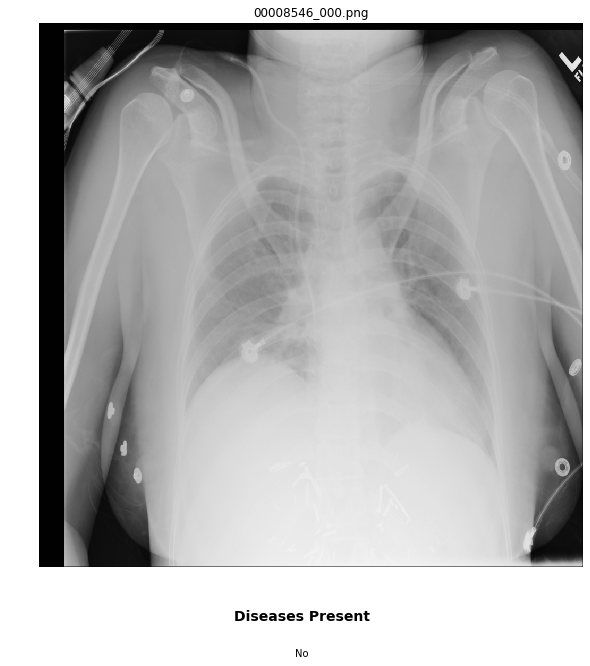

In [70]:
random_ix = np.random.randint(0, len(train_list))
random_train_path = train_list[random_ix]

random_image = show_labeled_xray(random_train_path, label_df)

<p>Let's inspect the image itself a bit to get a grasp on what we'll have to do.</p>

In [78]:
np_xray = np.array(random_image)
print('Image dimensions:',np_xray.shape)
print('Image pixel max:',np.amax(np_xray))
print('Image pixel min:',np.amin(np_xray))

Image dimensions: (1024, 1024)
Image pixel max: 252
Image pixel min: 0


<p>Looks like we've got a 1024px square image that ranges from 0 to 255 intensity. Things will be easier from a convolutional standpoint and computation standpoint since the image only has one color channel, however we'll have to normalize the image to be on a [0,1] scale rather than [0,255]. The final thing we need to do before that though is a bit of UNIX foo. Things will be easier on us later if we have a separate test and train directory layout for the images.</p>

In [97]:
train_dir = './data/images/train'
test_dir = './data/images/test'

if not os.path.exists(train_dir):
    print('Creating directory:',train_dir)
    os.mkdir(train_dir)
    
if not os.path.exists(test_dir):
    print('Creating directory:',test_dir)
    os.mkdir(test_dir)
 
for file in test_list:
    if os.path.exists(file):
        #print(test_dir+'/'+file[12:])
        os.rename(
            file,
            test_dir+'/'+file[12:]
        )

for file in train_list:
    if os.path.exists(file):
        #print(train_dir+'/'+file[12:])
        os.rename(
            file,
            train_dir+'/'+file[12:]
        )

<h3>Getting X and y</h3>

<p>Let's create our X and y features to train the data on.</p>

In [166]:
def create_X(id_list, base_dir, image_size=160):

    X = []
    
    num_xrays = len(id_list)

    for ix, image_path in enumerate(id_list):
        full_path = base_dir+'/'+image_path[12:]
        image = PIL.Image.open(full_path)
        image = image.resize((image_size, image_size), PIL.Image.NEAREST)
        image = np.array(image)
        image = image / 255.0
        X.append(image)
        
        if ix % 500 == 0:
            print(ix,'/',num_xrays,'samples loaded')
                
    return X

In [167]:
def create_y(label_df):

    y = []

    disease_names = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia',
        'No Finding'
    ]

    print('==Disease List==')
    for dis_ix, dis in enumerate(disease_names):
        print(dis_ix, dis)

    num_diseases = len(disease_names)

    for row_ix, row in label_df.iterrows():

        row['disease_list'] = np.zeros(num_diseases)

        for dis_ix, dis in enumerate(disease_names):
            if dis in row['labels']:
                row['disease_list'][dis_ix] = 1

        if row_ix % 500 == 0:
            print(row_ix, row['disease_list'])

        y.append(row['disease_list'])
        
    return y

In [168]:
train_X = create_X(train_list, train_dir)
train_y = create_y(label_df)

print(len(train_X))
print(len(train_y))

0 / 86524 samples loaded
500 / 86524 samples loaded
1000 / 86524 samples loaded
1500 / 86524 samples loaded
2000 / 86524 samples loaded
2500 / 86524 samples loaded
3000 / 86524 samples loaded
3500 / 86524 samples loaded
4000 / 86524 samples loaded
4500 / 86524 samples loaded
5000 / 86524 samples loaded
5500 / 86524 samples loaded
6000 / 86524 samples loaded
6500 / 86524 samples loaded
7000 / 86524 samples loaded
7500 / 86524 samples loaded
8000 / 86524 samples loaded
8500 / 86524 samples loaded
9000 / 86524 samples loaded
9500 / 86524 samples loaded
10000 / 86524 samples loaded
10500 / 86524 samples loaded
11000 / 86524 samples loaded
11500 / 86524 samples loaded
12000 / 86524 samples loaded
12500 / 86524 samples loaded
13000 / 86524 samples loaded
13500 / 86524 samples loaded
14000 / 86524 samples loaded
14500 / 86524 samples loaded
15000 / 86524 samples loaded
15500 / 86524 samples loaded
16000 / 86524 samples loaded
16500 / 86524 samples loaded


KeyboardInterrupt: 